In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Question 1. Fit a polynomial model 
of degree $M=10$ to the data below. Perform Lasso regularization, fitting the model over data1_1, selecting the optimal value of the regularization parameter over the data1_2 (based on validation R2) and testing performance over the data1_3.

Important - standardize the data before training Lasso model and apply the same $\mu$ and $\sigma$ defined over data1_1 to data1_2 and data1_3 during validation/testing (as we are not supposed to learn anything, including normalization coefficients from validation and test data; all the parameters of the model are to be learned from training data exclusively).

Visualize the final model against all the data from from training, validation and test samples on the same plot using different colors for points from different samples. For comparison also visualize the true model used to generate the data below - $y=x^4/100+x^3/20+x^2/3+2$.

Output the coefficients of the model.

In [2]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data1=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data1_2=data1.loc[40:49]
data1_3=data1.loc[50:59]
data1=data1.loc[0:39] 
data1.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [3]:
#generate regressors for data1, data1_2, data1_3
def GenerateRegressors(M):
    for p in range(2,M+1):
        data1['x%d'%p]=data1['x']**p
        data1_2['x%d'%p]=data1_2['x']**p
        data1_3['x%d'%p]=data1_3['x']**p

In [4]:
#consider just the model of degree M=10
GenerateRegressors(10)

In [5]:
for c in data1.columns:
    mean=data1[c].mean()
    std=data1[c].std()
    data1[c]=(data1[c]-data1[c].mean())/data1[c].std()
    data1_2[c]=(data1_2[c]-mean)/std
    data1_3[c]=(data1_3[c]-mean)/std

In [6]:
#fit Lasso for various alpha and tune it to optimize Validation R2
alphas=np.exp(np.linspace(-5,6.5,200))
def FitLasso(alphas):
    best_R2 = -1
    best_alpha = alphas[0]
    for i in alphas:
        lm=linear_model.Lasso(fit_intercept=True,alpha=i)
        lm.fit(data1.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']],data1['y'])
        y_predict=lm.predict(data1_2.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']])
        err_OS=y_predict - data1_2['y']
        R2_OS=1-np.var(err_OS)/np.var(data1_2['y'])
        if R2_OS > best_R2 :
            best_R2=R2_OS
            best_alpha=i
    return best_alpha
alpha_f=FitLasso(alphas)

In [7]:
alpha_f

0.0089952800654635161

In [8]:
#report test R2
Lasso=linear_model.Lasso(fit_intercept=True,alpha=alpha_f)
Lasso.fit(data1.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']],data1['y'])
p_IS=Lasso.predict(data1.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']])
err_IS=p_IS-data1['y']
R_2_IS_Lasso=1-np.var(err_IS)/np.var(data1['y'])
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))

Lasso_coef=Lasso.coef_
#Out of sample
p_OS=Lasso.predict(data1_3.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']])
err_OS=p_OS-data1_3['y']
R_2_OS_Lasso=1-np.var(err_OS)/np.var(data1_3['y'])
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.996463865009
The R-squared we found for OS Lasso is: 0.999973265585


In [9]:
Lasso_coef

array([ 0.23408425,  0.24184907,  0.44827538,  0.60577808,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

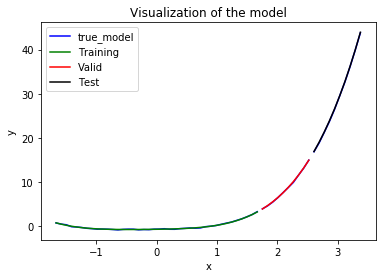

In [10]:
#visualize the model against all the data from training, validation and test samples 
plt.title('Visualization of the model')
plt.plot(data1['x'],data1['y'],label='true_model')
plt.plot(data1_2['x'],data1_2['y'],'b',label='')
plt.plot(data1_3['x'],data1_3['y'],'b',label='')
plt.plot(data1['x'],Lasso.predict(data1.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),'g',label='Training')
plt.plot(data1_2['x'],Lasso.predict(data1_2.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),'r',label='Valid')
plt.plot(data1_3['x'],Lasso.predict(data1_3.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),'k',label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

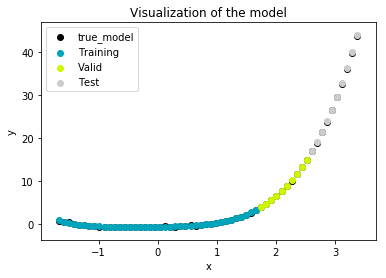

In [12]:
#visualize the model against all the data from training, validation and test samples 
cmap=plt.cm.spectral(np.linspace(0, 1,4))
plt.title('Visualization of the model')
plt.scatter(data1['x'],data1['y'],color=cmap[0],label='true_model')
plt.scatter(data1_2['x'],data1_2['y'],color=cmap[0],label='')
plt.scatter(data1_3['x'],data1_3['y'],color=cmap[0],label='')
plt.scatter(data1['x'],Lasso.predict(data1.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),color=cmap[1],label='Training')
plt.scatter(data1_2['x'],Lasso.predict(data1_2.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),color=cmap[2],label='Valid')
plt.scatter(data1_3['x'],Lasso.predict(data1_3.loc[:,['x','x2','x3','x4','x5','x6','x7','x8','x9','x10']]),color=cmap[3],label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Question 2. P-values and hypothesis testing
Suppose that a multiple regression with 7 regressors gave the following p-values for each of them:
0.02, 0.1, 3e-15, 0.04, 0.001, 0.06, 0.03.

For how many regressors you would reject the null-hypothesis that their corresponding regression coefficient is zero at the 95% confidence level? Please explain.

# Answer here
The multiple regression with 7 regressors  gives p-values 0.02,0.1,3e-15,0.04,0.001,0.06,0.03. 
The p-value signifies the level of confidence that the regression coefficient is zero i.e the regressor is not important to the model.
Thus I would reject the null hypothesis for 5 regressors whose p value is lower than 0.05.

### Question 3. Confidence intervals
Assume we perform a regression and get an estimate 10 for the slope coefficient for the regressor of interest. Select all statements that can not be true for its confidence intervals:

a. 95%-confidence interval is [-5, 5]

b. 99%-conficence interval is [9.99,10.01]

c. 95%-confidence interval is [9,100]

d. 99%-confidence interval is [8, 12], while 95%-confidence interval is [9, 11].

Explain your choices

# Answer here
Confidence interval = 10 +- value

a)This cannot be true for the confidence interval since both are below 10.

c) This cannot be true for the confidence interval since the difference between both upper limit(100) and lower limit(9) and 10(the coefficient) is different.


# Principal component regression

### Question 4

Using the median price per sq.foot from Zillow data below as reported for 2018-08, fit the linear model using N leading principal components of the 311 data and perform cross-validation. Visualize performance depending on the number N of leading PCs. Specifically: 
    1. implement a 20-times-cross-validation as a function of N returing OS R2
    2. run it for N=1,2,...30, return the best N and the corresponding R2
    3. mark it with a vertical line on the plot and put the value of N and the corresponding R2 as text labels
**Important:** keep training pca over the training sample only, applying the same pca transform to the test samples in order to prepare regressors for them

In [93]:
# Write code here
zillow=pd.read_csv( 'data/Zip_MedianListingPricePerSqft_AllHomes.csv' , index_col=0 )
zillow.head()
#zillow=zillow.loc[zillow['2018-08']>0]
zillow=zillow.loc[:,['2018-08']]
zillow.head()

,2018-08
RegionName,
10023,1619.794484
60614,436.111111
79936,91.668726
10002,2030.259366
926,102.270729


**Load/process 311 data**

In [94]:
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [95]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [96]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [97]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [98]:
scaler311 = preprocessing.StandardScaler().fit(data311)
data311S=scaler311.transform(data311) 
data311S=pd.DataFrame(data311S,data311.index,columns=data311.columns.tolist())
data311S.head()

,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,-1.192004,-0.326981,0.473895,-0.360759,-0.359967,3.267022,-1.184047,-0.739934,-0.455918,-0.191365,...,-0.751453,-0.787455,-0.709215,8.039141,12.244000,-0.741739,-1.139737,-2.041666,-0.288943,-0.19576
10001.0,-1.192004,1.061418,1.139549,-0.360759,-0.359967,-0.452131,1.375824,3.263713,0.091709,0.011741,...,0.073718,-0.787455,-0.579382,0.493629,-0.130883,-0.543873,-0.773297,0.828628,-0.288943,-0.19576
10002.0,-0.639235,-0.326981,0.220570,-0.360759,-0.359967,0.287745,0.211237,0.607121,0.207392,0.546669,...,0.081451,-0.547753,-0.551955,-0.116883,-0.040107,-0.502075,-0.363001,-0.502830,-0.288943,-0.19576
10003.0,-0.638891,0.514387,1.065629,-0.360759,0.840674,1.168284,0.677487,0.136195,0.207804,0.054799,...,0.415337,1.850907,-0.630536,0.171599,0.133978,-0.453963,-0.584581,-0.530388,-0.288943,-0.19576
10004.0,-1.192004,-0.326981,0.620151,-0.360759,-0.359967,0.604681,0.518683,-0.246772,-0.455918,0.709292,...,0.468264,0.967663,-0.709215,0.845166,2.168661,-0.741739,-1.139737,-0.754947,-0.288943,-0.19576


In [99]:
MedianZillow=zillow.merge(data311S,left_index=True,right_index=True)
MedianZillow.head()

,2018-08,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
10023.0,1619.794484,-0.940226,-0.326981,0.961021,-0.360759,0.459836,1.627050,1.040314,-0.095692,-0.455918,...,-0.296202,1.177801,-0.709215,1.621865,0.256921,-0.512496,1.286266,-0.334801,-0.288943,-0.19576
10002.0,2030.259366,-0.639235,-0.326981,0.220570,-0.360759,-0.359967,0.287745,0.211237,0.607121,0.207392,...,0.081451,-0.547753,-0.551955,-0.116883,-0.040107,-0.502075,-0.363001,-0.502830,-0.288943,-0.19576
10016.0,1456.997085,-0.717206,0.657892,0.796348,-0.360759,-0.359967,-0.425693,1.085787,0.916746,-0.455918,...,-0.166110,-0.225934,-0.617117,2.244808,-0.168804,-0.545238,-0.099985,-0.389446,-0.288943,-0.19576
11235.0,575.000000,0.033931,-0.326981,-0.156696,-0.360759,-0.359967,0.194736,2.054352,-0.166750,1.853358,...,-0.235950,-0.602008,0.112019,-0.066517,-0.102413,0.685973,0.491344,-0.068479,-0.288943,-0.19576
10009.0,1798.307475,-0.372578,0.657075,0.700924,-0.360759,-0.359967,-0.202010,0.721031,0.521250,0.708507,...,0.418260,1.176237,-0.295117,0.469206,-0.150386,-0.657594,0.158873,-0.251857,0.793608,-0.19576


In [100]:
data=MedianZillow.iloc[:,1:]
Y=MedianZillow['2018-08']


In [101]:

R_IS=[]; R_OS=[]
def validation(pc_components):
    n=20 #number of runs
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:],Y,test_size=0.3) #randomly split data into training (70%) and test (30%)
        pca = PCA(pc_components) #take only 5 leading principal components to get enough data but avoid overfitting
        P_train=pca.fit_transform(X_train)
        Ridge.fit(X_train,y_train)
        P_test=pca.transform(X_test)
        y_pred=np.asarray(res.predict(sm.add_constant(P_test)))
        R_IS.append(res.rsquared)                                                                     
        R_OS.append(1-((y_pred-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
    return(np.mean(R_OS))

In [102]:
best_R2=-1
best_N=1
R2=[]
N=[]
for i in range(1,31):
    r2=validation(i)
    R2.append(r2)
    N.append(i)
    if (r2 > best_R2):
        best_R2=r2
        best_N=i
print("The best value of R2 is "+ str(best_R2) + " at  N value " + str(best_N) )

The best value of R2 is 0.8385025269987713 at  N value 30


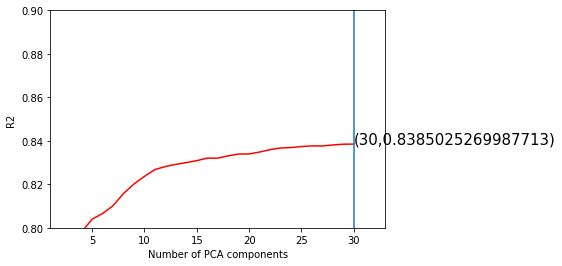

In [104]:
plt.plot(N,R2,'r')
plt.axvline(x=best_N)
plt.xlabel('Number of PCA components')
plt.ylabel('R2 ')
plt.text(best_N, best_R2, '('+str(best_N) +","+str(best_R2)+')', fontsize=15)
plt.ylim(0.8,0.9)
plt.xlim(1,33)
plt.show()

### Question 5
1. Using the Zillow dataset from question 4, run PCA on the price dynamics for zip codes over the last 5 years 
    1. take only those zip codes within NYC having price defined for the last 60 months from 2013-09 till 2018-08:
    2. normalize each zip code timeline by average price over this period
    3. standardize those normalized prices per month and use them as features
    4. run pca over those features

2. Visualize zip codes in the 2d space of first two principal components, coloring them by borough (feel free to use borough definition from the class notebook). 

In [2]:
# Write code here
df=pd.read_csv( 'data/Zip_MedianListingPricePerSqft_AllHomes.csv' , index_col=0 )
df.head()
#df=df.loc[(df.index>=10000)&(df.index<11500)]
df=df.loc[df.City=='New York']

In [3]:
df=df.iloc[:,49:]
df.head()

,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,1671.539961,1692.579505,1671.539961,1626.483292,1687.241963,1679.678610,1647.985348,1602.992987,1693.398425,1679.748823,...,1954.992968,1983.055556,1963.986600,1702.573836,1522.948540,1568.100358,1612.378790,1569.371728,1599.538839,1619.794484
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2041.247701,2043.165468,2063.785322,2012.302285,2015.369804,2026.353276,2022.274326,2013.831259,1997.942387,2030.259366
10016,1208.647968,1240.693215,1338.257652,1288.714051,1341.698842,1287.390942,1290.475408,1361.205586,1357.735068,1343.503937,...,1546.285641,1557.564684,1538.800705,1345.275276,1327.586207,1389.792068,1433.631891,1433.902938,1444.833625,1456.997085
11235,442.216981,442.743009,437.367117,436.607143,436.303571,435.454545,430.821918,435.342870,434.631891,440.149254,...,589.335828,581.314948,578.947368,566.937120,561.356996,582.314205,584.002443,576.515881,577.477570,575.000000
10009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1808.655408,1844.537815,1840.555151,1781.808594,1730.285480,1760.563380,1731.472570,1758.405276,1761.241970,1798.307475


In [178]:
df.shape

(100, 60)

In [4]:
df.dropna(inplace=True)

In [180]:
df.shape

(62, 60)

In [5]:
TotalZip=df.sum(axis=1) #total price  per zip code over the period
df=df.div(df.sum(axis=1), axis=0)
df.head()

,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,0.015199,0.015390,0.015199,0.014789,0.015341,0.015273,0.014984,0.014575,0.015397,0.015273,...,0.017776,0.018031,0.017858,0.015481,0.013847,0.014258,0.014661,0.014270,0.014544,0.014728
10016,0.013540,0.013899,0.014992,0.014437,0.015030,0.014422,0.014456,0.015249,0.015210,0.015050,...,0.017322,0.017448,0.017238,0.015070,0.014872,0.015569,0.016060,0.016063,0.016186,0.016322
11235,0.014084,0.014100,0.013929,0.013905,0.013895,0.013868,0.013721,0.013865,0.013842,0.014018,...,0.018769,0.018514,0.018438,0.018056,0.017878,0.018546,0.018599,0.018361,0.018391,0.018313
10029,0.014043,0.014375,0.013020,0.012532,0.013021,0.013326,0.013805,0.015184,0.014273,0.013841,...,0.019569,0.019569,0.019464,0.019219,0.018764,0.019063,0.019234,0.019273,0.019007,0.018848
10462,0.013754,0.013668,0.013989,0.014069,0.014383,0.014308,0.014366,0.014683,0.014413,0.014413,...,0.017995,0.018344,0.018221,0.019975,0.020178,0.020531,0.021548,0.020957,0.020762,0.020003


In [6]:
scalerdf = preprocessing.StandardScaler().fit(df)
dfS=scalerdf.transform(df) 
dfS=pd.DataFrame(dfS,index=df.index,columns=df.columns.tolist())
dfS.head()

,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,1.220135,1.335753,1.129128,0.801541,1.177787,1.022829,0.652839,0.230374,0.896289,0.642302,...,-0.956331,-0.758564,-0.869083,-2.250364,-2.823338,-2.871479,-2.722747,-2.799485,-2.640852,-2.510163
10016,-0.365078,-0.074759,0.935144,0.454264,0.892321,0.309979,0.177163,0.846083,0.726141,0.444338,...,-1.326908,-1.220310,-1.346369,-2.541357,-2.191588,-2.050329,-1.855409,-1.752943,-1.711606,-1.615298
11235,0.154732,0.116034,-0.061527,-0.070096,-0.149356,-0.153923,-0.485717,-0.419098,-0.516072,-0.473769,...,-0.144969,-0.375917,-0.421560,-0.424308,-0.338450,-0.186066,-0.281848,-0.412313,-0.463109,-0.497652
10029,0.115803,0.375810,-0.914632,-1.423776,-0.951921,-0.608491,-0.409827,0.787072,-0.124519,-0.631295,...,0.508190,0.460461,0.368610,0.400701,0.207994,0.137962,0.111563,0.119952,-0.114798,-0.196775
10462,-0.160143,-0.293188,-0.005834,0.091780,0.298046,0.214642,0.095218,0.328790,0.002244,-0.122586,...,-0.777037,-0.510731,-0.588762,0.936718,1.079454,1.057352,1.545691,1.102400,0.878399,0.451360


Text(0,0.5,'variance')

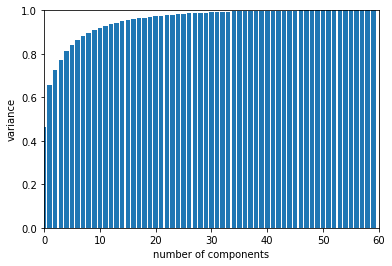

In [7]:
n=60 # how many eigenvectors we choose
pca = PCA(n)
P = pca.fit_transform(dfS) #find principal components
eigenvalues = pca.explained_variance_
plt.bar(np.arange(n), eigenvalues.cumsum()/eigenvalues.sum(),align='center');
plt.ylim(0,1)
plt.xlim(0,60)
plt.xlabel('number of components')
plt.ylabel('variance')

In [8]:
Z=np.array(dfS.index)
manhattanInd=(Z>10000)&(Z<10300) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
D=Z*0
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

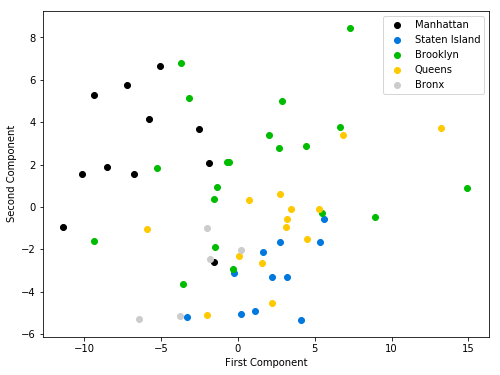

In [10]:
listb=['Manhattan','Staten Island', 'Brooklyn', 'Queens','Bronx']
plt.figure(1, figsize=(8, 6))
cmap=plt.cm.spectral(np.linspace(0, 1,5))
for d in range(1,6):
    ind=D==d 
    plt.scatter(P[ind, 0], P[ind, 1], color=cmap[d-1,:], label=listb[d-1])
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.legend()
plt.show()